In [1]:
# HCASE Experiments t-SNE
#
# Author: Gergely Zahoranszky-Kohalmi, PhD
#
# Email: gergely.zahoranszky-kohalmi@nih.gov
#
# Organization: National Center for Advancing Translational Sciences (NCATS/NIH)
#

In [2]:
import pandas as pd

import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


import morgantsne




In [3]:
# Config section


fname_drugs = '../data/STD_drugbank_approved_structures_v5.txt'
fname_knn = '../data/rnd_5_app_drugs_drugbank_knn_5.tab'

#fname_out_global_corr = ''
#fname_out_local_corr = ''

fname_out_drug_tSNE_embedding = '../data/drug_tSNE_embedding.tab'

fname_out_drugs_knn_tsne_plot = '../plots/tsne/orig_tsne.png'

fname_out_reduced_drug_tSNE_embedding = '../data/reduced_drug_tSNE_embedding.tab'

fname_out_red_drugs_knn_tsne_plot = '../plots/tsne/red_orig_tsne.png'

# t-SNE parameters

metric = 'jaccard'
perplexity_values = [5, 10, 20, 30, 40, 50]
learning_rate = 200.0
n_iter = 1000
n_jobs = 4


# Morgan fingerprint parameters

fp_radius = 3
fp_length = 2048




do_sampling = False

random_seed = 55555
sample_size = 100
sample_fraction = 0.9




In [4]:
# Import datasets

df_drugs = pd.read_csv (fname_drugs, sep = '\t')

df_knn = pd.read_csv(fname_knn, sep ='\t')



In [5]:
# Clean-up datasets


df_drugs = df_drugs.rename (columns = {'Structure': 'structure', 'ID': 'id'})
df_drugs = df_drugs[['id', 'structure']].copy()



In [6]:
# Sampling

if do_sampling:
    df_drugs = df_drugs.sample (n = sample_size, random_state = random_seed)
    
    print (df_drugs.shape[0])
    print (df_drugs.head)

In [7]:
# Functions


def sample_drugs (df_drugs, df_knn, sample_fraction, random_seed):
   
    df_drugs_orig = df_drugs
    nr = df_drugs.shape[0]

    nr = math.ceil(nr * sample_fraction)
    df_drugs = df_drugs.sample (n = nr, random_state = random_seed)

    df_check = df_knn[~df_knn['id'].isin(list(df_drugs['id']))]
    df_add = df_drugs_orig[df_drugs_orig['id'].isin(list(df_check['id']))]
    
    df_drugs = df_drugs.append(df_add, ignore_index = True)

    # Extra check
    df_check = df_knn[~df_knn['id'].isin(list(df_drugs['id']))]
 
    if not df_check.empty:
        print (df_check)
        print ('[ERROR] Some of the selected KNN molecules were not included in the set where 10 percent was left out.')
        sys.exit(-2)
    
    return (df_drugs)



# These functions are for plotting, not for main (tSNE embedding) logic

def separate_query_from_target_mols (df_knn):
    df_target = df_knn[['knn_target_id', 'knn_target_structure', 'knn_color', 'data_label']].copy()
    df_target['knn_type'] = 'nn'
    df_target = df_target.rename(columns = {
        'knn_target_id': 'id',
        'knn_target_structure': 'smiles'
    #    'knn_color': 'color'
    })
    
    df_query = df_knn[['knn_query_id', 'knn_query_structure', 'knn_color', 'data_label']].copy()
    df_query['knn_type'] = 'parent'
    df_query = df_query.rename(columns = {
        'knn_query_id': 'id',
        'knn_query_structure': 'smiles'
    #    'knn_color': 'color'
    })

    df_query = df_query.groupby(['id'], as_index = False).agg({
        'smiles': 'first',
         'knn_color': 'first',
         'knn_type': 'first',
         'data_label': 'first'
    })

    df_query = df_query.reset_index(drop = True)

    df_knn = df_query.append(df_target, ignore_index = True)

    return (df_knn) 



def panel_plot_multi_tsne (subfig, df_knn, df_embedded, subfig_label):

    df = df_knn.merge (df_embedded, on = 'id', how = 'inner')

 
    df_1 = df[df['knn_color'] == 1].copy()
    df_1_parent = df_1[df_1['knn_type'] == 'parent'].copy()
    df_1_nn = df_1[df_1['knn_type'] == 'nn'].copy()

    df_2 = df[df['knn_color'] == 2].copy()
    df_2_parent = df_2[df_2['knn_type'] == 'parent'].copy()
    df_2_nn = df_2[df_2['knn_type'] == 'nn'].copy()


    df_3 = df[df['knn_color'] == 3].copy()
    df_3_parent = df_3[df_3['knn_type'] == 'parent'].copy()
    df_3_nn = df_3[df_3['knn_type'] == 'nn'].copy()


    df_4 = df[df['knn_color'] == 4].copy()
    df_4_parent = df_4[df_4['knn_type'] == 'parent'].copy()
    df_4_nn = df_4[df_4['knn_type'] == 'nn'].copy()


    df_5 = df[df['knn_color'] == 5].copy()
    df_5_parent = df_5[df_5['knn_type'] == 'parent'].copy()
    df_5_nn = df_5[df_5['knn_type'] == 'nn'].copy()




 
    subfig.scatter(df_1_parent['Dim_1'].values, df_1_parent['Dim_2'].values, c = 'blue', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_1_nn['Dim_1'].values, df_1_nn['Dim_2'].values, c = 'blue', alpha = 0.7, marker = '+', s = 100)

    for i, txt in enumerate(list(df_1_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_1_nn['Dim_1'].values[i], df_1_nn['Dim_2'].values[i])))

    subfig.scatter(df_2_parent['Dim_1'].values, df_2_parent['Dim_2'].values, c = 'green', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_2_nn['Dim_1'].values, df_2_nn['Dim_2'].values, c = 'green', alpha = 0.7, marker = '+', s = 100)

    for i, txt in enumerate(list(df_2_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_2_nn['Dim_1'].values[i], df_2_nn['Dim_2'].values[i])))
    


    subfig.scatter(df_3_parent['Dim_1'].values, df_3_parent['Dim_2'].values, c = 'purple', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_3_nn['Dim_1'].values, df_3_nn['Dim_2'].values, c = 'purple', alpha = 0.7, marker = '+', s = 100)

    for i, txt in enumerate(list(df_3_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_3_nn['Dim_1'].values[i], df_3_nn['Dim_2'].values[i])))



    subfig.scatter(df_4_parent['Dim_1'].values, df_4_parent['Dim_2'].values, c = 'orangered', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_4_nn['Dim_1'].values, df_4_nn['Dim_2'].values, c = 'orangered', alpha = 0.7, marker = '+', s = 100)


    for i, txt in enumerate(list(df_4_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_4_nn['Dim_1'].values[i], df_4_nn['Dim_2'].values[i])))



    subfig.scatter(df_5_parent['Dim_1'].values, df_5_parent['Dim_2'].values, c = 'aqua', alpha = 0.7, marker = 'x', s = 200)
    subfig.scatter(df_5_nn['Dim_1'].values, df_5_nn['Dim_2'].values, c = 'aqua', alpha = 0.7, marker = '+', s = 100)

    for i, txt in enumerate(list(df_5_nn['data_label'])):
        subfig.annotate('  ' + txt, ((df_5_nn['Dim_1'].values[i], df_5_nn['Dim_2'].values[i])))


    subfig.set_title (subfig_label, fontsize=20)
    subfig.set_xlabel ('Dim 1', fontsize=16)
    subfig.set_ylabel ('Dim 2', fontsize=16)
        
    return (subfig)

In [8]:
# Workflow
# tSNE embedding of full data set

df_knn = separate_query_from_target_mols (df_knn)

df_res = pd.DataFrame ()
first = True
for i in range(len(perplexity_values)):
    perplexity_val = perplexity_values[i]

    df_embedding = morgantsne.embed(df_drugs, perplexity_val, fp_radius, fp_length, metric, random_seed,  learning_rate, n_iter)
    df_embedding['perplexity'] = perplexity_val
    df_embedding['fp_type'] = 'Morgan impl. in RDKit'
    df_embedding['fp_radius'] = fp_radius
    df_embedding['fp_length'] = fp_length
    
    if first:
        df_res = df_embedding
        first = False
    
    else:
        df_res = df_res.append (df_embedding, ignore_index = True)

        
df_res = df_res[['id', 'Dim_1', 'Dim_2', 'structure', 'fp_str', 'fp_type', 'fp_radius', 'fp_length', 'perplexity']].copy()


df_res.to_csv (fname_out_drug_tSNE_embedding, sep = '\t', index = False)


[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 5, learning rate: 200.000000, n_iteration: 1000  ... 


[05:36:51] Explicit valence for atom # 21 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 3 O, 3, is greater than permitted
[05:36:51] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 11 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 20 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:36:51] Explicit valence for atom # 25 N, 

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 10, learning rate: 200.000000, n_iteration: 1000  ... 


[05:36:57] Explicit valence for atom # 21 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 3 O, 3, is greater than permitted
[05:36:57] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 11 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 20 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:36:57] Explicit valence for atom # 25 N, 

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 20, learning rate: 200.000000, n_iteration: 1000  ... 


[05:37:03] Explicit valence for atom # 21 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 3 O, 3, is greater than permitted
[05:37:03] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 20 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:37:03] Explicit valence for atom # 25 N, 

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 30, learning rate: 200.000000, n_iteration: 1000  ... 


[05:37:09] Explicit valence for atom # 21 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 3 O, 3, is greater than permitted
[05:37:09] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 11 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 20 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:37:09] Explicit valence for atom # 25 N, 

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 40, learning rate: 200.000000, n_iteration: 1000  ... 


[05:37:16] Explicit valence for atom # 21 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 3 O, 3, is greater than permitted
[05:37:16] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 11 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 20 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:37:16] Explicit valence for atom # 25 N, 

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 50, learning rate: 200.000000, n_iteration: 1000  ... 


[05:37:22] Explicit valence for atom # 21 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 3 O, 3, is greater than permitted
[05:37:22] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 11 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 2 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 20 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 17 N, 4, is greater than permitted
[05:37:22] Explicit valence for atom # 25 N, 

 .. done


In [9]:
# tSNE embedding of 90% reduced dataset


df_drugs_red = sample_drugs (df_drugs, df_knn, sample_fraction, random_seed)

df_res_red = pd.DataFrame ()
first = True
for i in range(len(perplexity_values)):
    perplexity_val = perplexity_values[i]

    df_embedding_red = morgantsne.embed(df_drugs_red, perplexity_val, fp_radius, fp_length, metric, random_seed,  learning_rate, n_iter)
    df_embedding_red['perplexity'] = perplexity_val
    df_embedding_red['fp_type'] = 'Morgan (RDKit implementation)'
    df_embedding_red['fp_radius'] = fp_radius
    df_embedding_red['fp_length'] = fp_length
    
    if first:
        df_res_red = df_embedding_red
        first = False
    
    else:
        df_res_red = df_res_red.append (df_embedding_red, ignore_index = True)

        
df_res_red = df_res_red[['id', 'Dim_1', 'Dim_2', 'structure', 'fp_str', 'fp_type', 'fp_radius', 'fp_length', 'perplexity']].copy()


df_res_red.to_csv (fname_out_reduced_drug_tSNE_embedding, sep = '\t', index = False)


[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 5, learning rate: 200.000000, n_iteration: 1000  ... 


[05:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 24 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 8 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 10 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 3 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 28 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:37:29] Explicit valence for atom # 6 N,

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 10, learning rate: 200.000000, n_iteration: 1000  ... 


[05:54:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 24 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 8 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 10 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 3 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 28 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:54:54] Explicit valence for atom # 6 N,

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 20, learning rate: 200.000000, n_iteration: 1000  ... 


[05:54:59] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 24 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 8 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 10 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 3 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 28 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:54:59] Explicit valence for atom # 6 N,

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 30, learning rate: 200.000000, n_iteration: 1000  ... 


[05:55:05] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 24 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 8 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 10 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 3 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 28 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:55:05] Explicit valence for atom # 6 N,

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 40, learning rate: 200.000000, n_iteration: 1000  ... 


[05:55:10] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:55:10] Explicit valence for atom # 24 N, 4, is greater than permitted
[05:55:10] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:55:10] Explicit valence for atom # 8 N, 4, is greater than permitted
[05:55:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 3 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 28 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:55:11] Explicit valence for atom # 6 N,

 .. done
[*] Computing t-SNE embedding using Morgan fingerprints (rad: 3, length: 2048) applying metric: jaccard, perplexity 50, learning rate: 200.000000, n_iteration: 1000  ... 


[05:55:16] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 24 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 16 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 8 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 10 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 18 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 3 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 12 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 28 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 6 N, 4, is greater than permitted
[05:55:16] Explicit valence for atom # 6 N,

 .. done


In [10]:
print (df_drugs.head)

<bound method NDFrame.head of            id                                          structure  is_valid
0     DB00006  CCC(C)C(NC(=O)C(CCC(O)=O)NC(=O)C(CCC(O)=O)NC(=...      True
1     DB00014  CC(C)CC(NC(=O)C(COC(C)(C)C)NC(=O)C(CC1=CC=C(O)...      True
2     DB00035  NC(=N)NCCCC(NC(=O)C1CCCN1C(=O)C2CSSCCC(=O)NC(C...      True
3     DB00050  CC(C)CC(NC(=O)C(CCCNC(N)=O)NC(=O)C(CC1=CC=C(O)...      True
4     DB00080  CCCCCCCCCC(=O)NC(CC1=C[NH]C2=C1C=CC=C2)C(=O)NC...      True
...       ...                                                ...       ...
2065  DB13518   OC1C(O)C(OC2C(O)C(O)C(OP)OC2C(O)=O)OC(C1P)C(O)=O      True
2066  DB13872     CN1C(=O)C(O)N=C(C2=CC=CC=C2Cl)C3=C1C=CC(=C3)Cl      True
2067  DB13873    CC(C)(OC1=CC=C(C=C1)C(=O)C2=CC=C(Cl)C=C2)C(O)=O      True
2068  DB13874  CC(C)(O)CNC1=NC(=NC(=N1)NC2=CC(=NC=C2)C(F)(F)F...      True
2069  DB13878  CO[C@H](C)[C@H](N=C(O)OC)C(=O)N1CCC[C@H]1C2=NC...      True

[2070 rows x 3 columns]>


<Figure size 640x480 with 0 Axes>

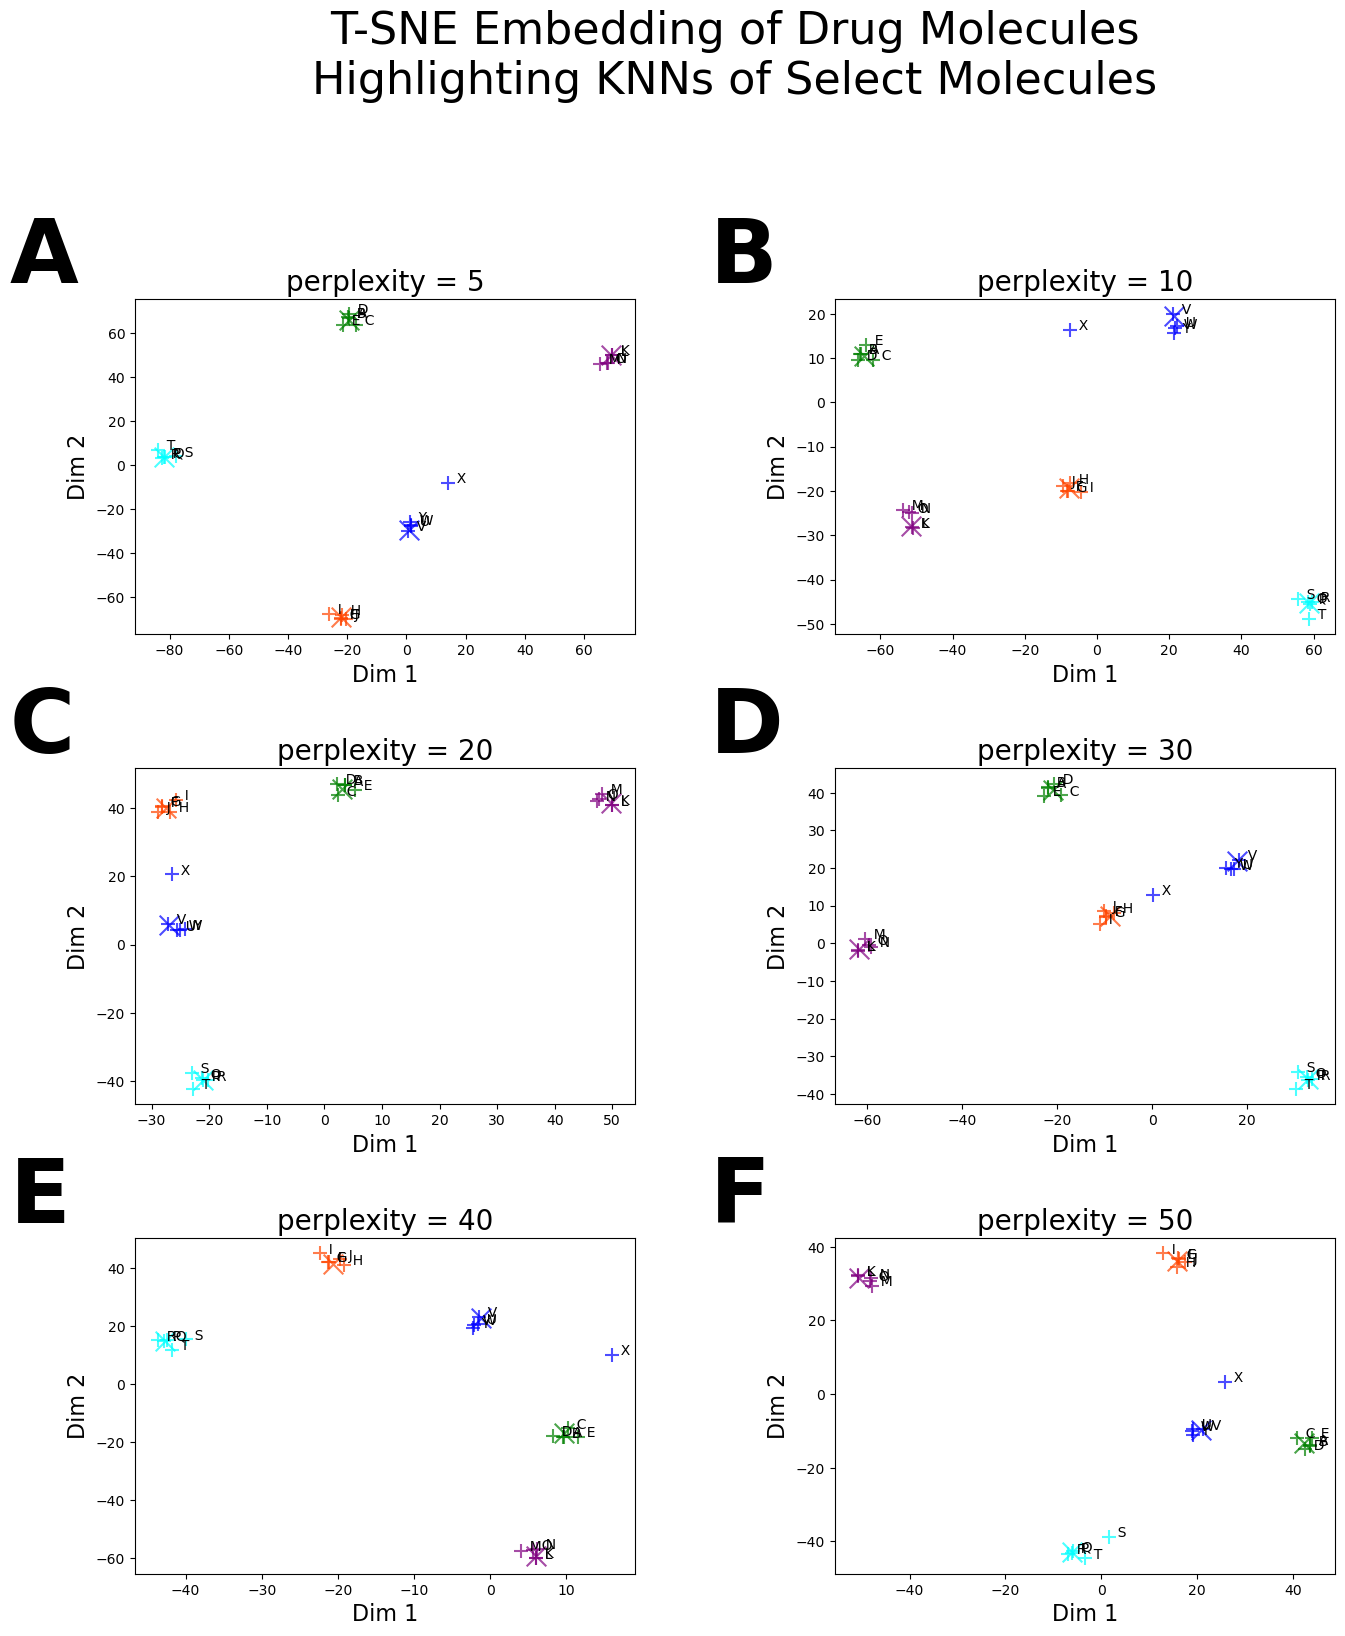

In [11]:
# Plotting
# Full data set

#df_knn = pd.read_csv(fname_knn, sep ='\t')


#df_knn = separate_query_from_target_mols (df_knn)



fig = plt.figure()

fig, subfigures = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 17))


#title_str = 'Original tSNE KNN (k=5)\n Perplexity = ' +  str(perplexity_val)

for i in range(len(perplexity_values)):
    perplexity_val = perplexity_values[i]
    df_embedded = df_res[df_res['perplexity'] == perplexity_val].copy()

    panel_x = int (math.floor(float(i) / 2.0))
    panel_y = i % 2

    
    subfig_label = 'perplexity = ' + str(perplexity_val)
    
    panel_plot_multi_tsne (subfigures[panel_x][panel_y], df_knn, df_embedded, subfig_label)


    
subfigures[0][0].text(-0.25, 1.25, "A", transform=subfigures[0][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[0][1].text(-0.25, 1.25, "B", transform=subfigures[0][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[1][0].text(-0.25, 1.25, "C", transform=subfigures[1][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[1][1].text(-0.25, 1.25, "D", transform=subfigures[1][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[2][0].text(-0.25, 1.25, "E", transform=subfigures[2][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[2][1].text(-0.25, 1.25, "F", transform=subfigures[2][1].transAxes,
            fontsize=64, fontweight='bold', va='top')




fig.suptitle('T-SNE Embedding of Drug Molecules\nHighlighting KNNs of Select Molecules', fontsize = 32, y = 1.02)



plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.4)

plt.savefig (fname_out_drugs_knn_tsne_plot, dpi=300)

plt.show()



#do_analysis (df_drugs, df_knn, perplexity_val)
#do_left_out_analysis (df_drugs, df_knn, perplexity_val)

<Figure size 640x480 with 0 Axes>

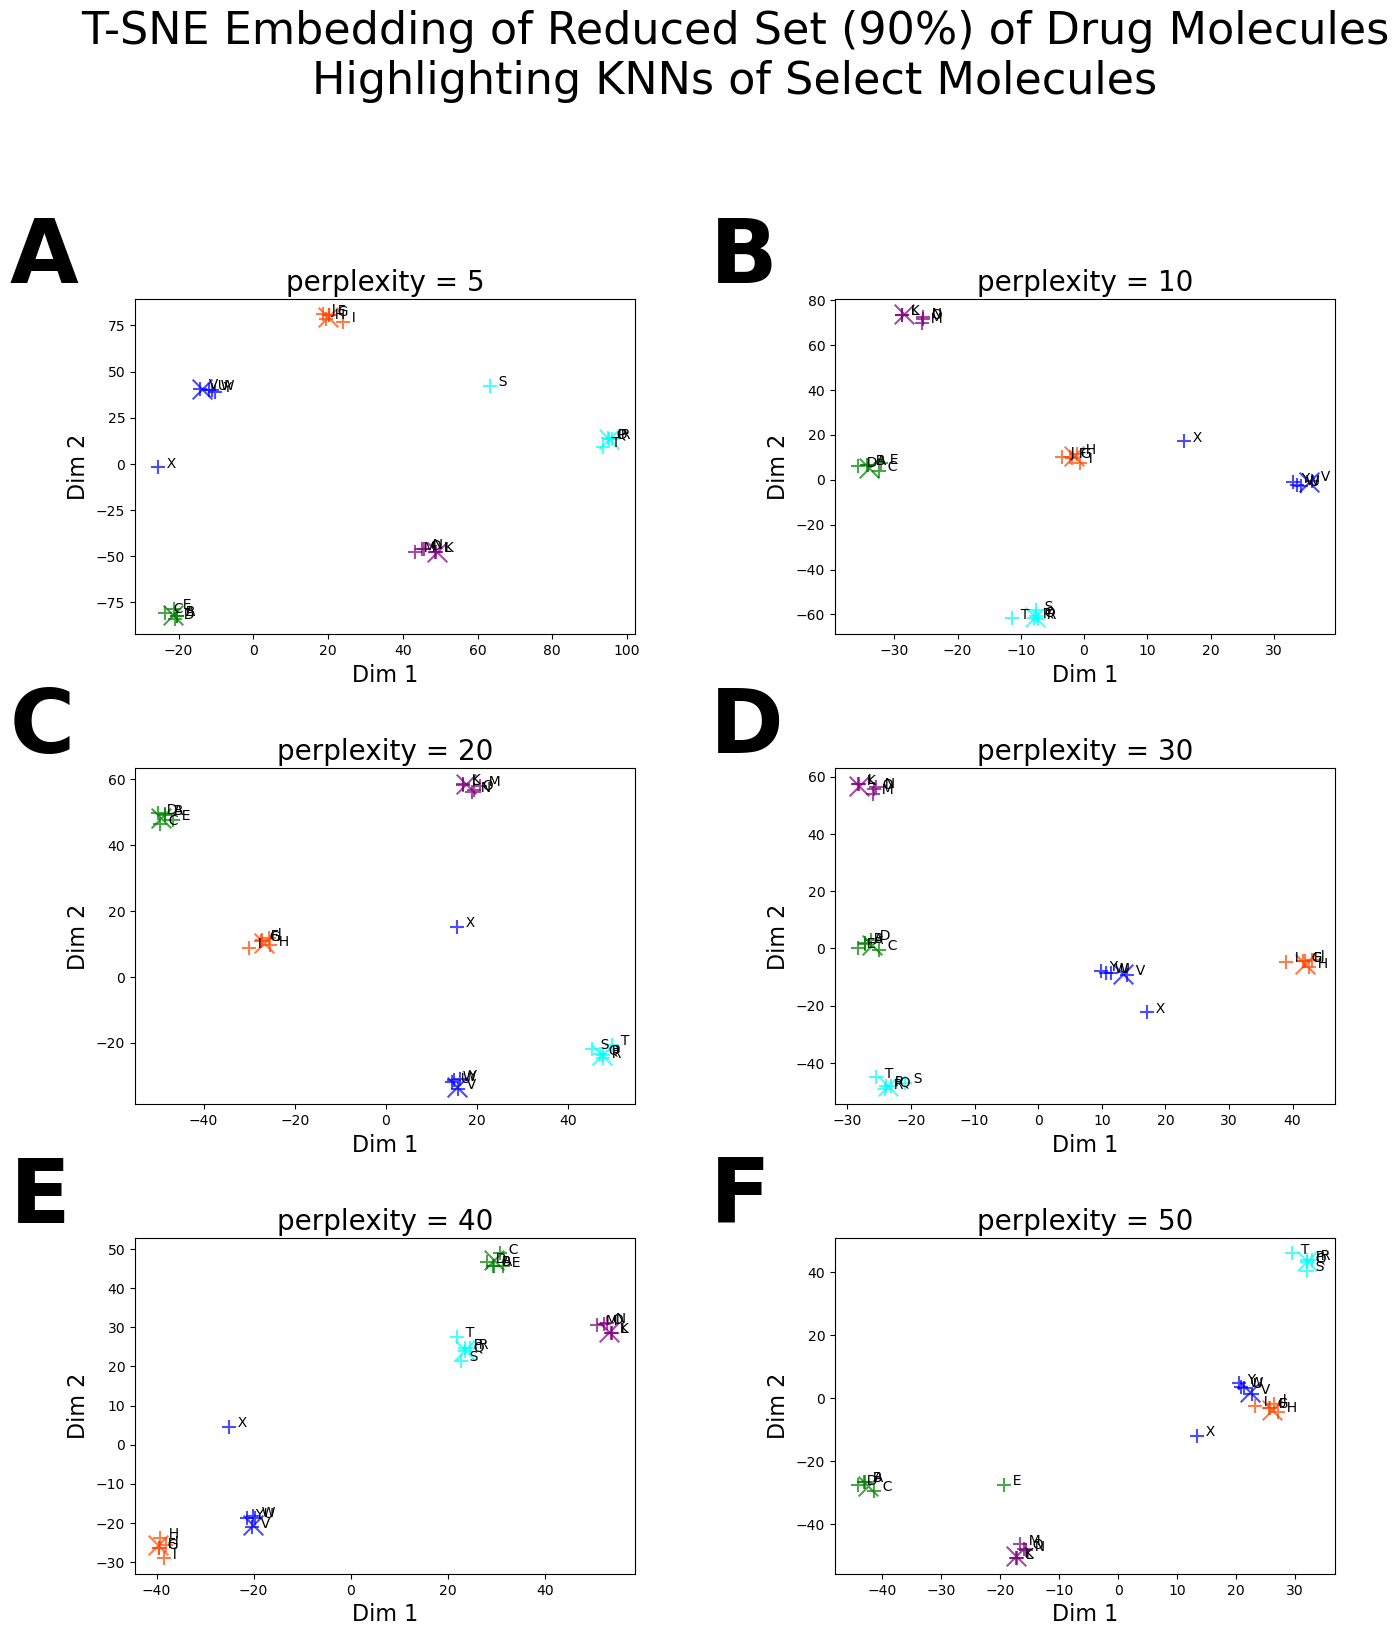

In [12]:
# Plotting
# Reduced data set

#df_knn = pd.read_csv(fname_knn, sep ='\t')


#df_knn = separate_query_from_target_mols (df_knn)



fig = plt.figure()

fig, subfigures = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 17))


#title_str = 'Original tSNE KNN (k=5)\n Perplexity = ' +  str(perplexity_val)

for i in range(len(perplexity_values)):
    perplexity_val = perplexity_values[i]
    df_embedded = df_res_red[df_res_red['perplexity'] == perplexity_val].copy()

    panel_x = int (math.floor(float(i) / 2.0))
    panel_y = i % 2

    
    subfig_label = 'perplexity = ' + str(perplexity_val)
    
    panel_plot_multi_tsne (subfigures[panel_x][panel_y], df_knn, df_embedded, subfig_label)

subfigures[0][0].text(-0.25, 1.25, "A", transform=subfigures[0][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[0][1].text(-0.25, 1.25, "B", transform=subfigures[0][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[1][0].text(-0.25, 1.25, "C", transform=subfigures[1][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[1][1].text(-0.25, 1.25, "D", transform=subfigures[1][1].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[2][0].text(-0.25, 1.25, "E", transform=subfigures[2][0].transAxes,
            fontsize=64, fontweight='bold', va='top')
subfigures[2][1].text(-0.25, 1.25, "F", transform=subfigures[2][1].transAxes,
            fontsize=64, fontweight='bold', va='top')



fig.suptitle('T-SNE Embedding of Reduced Set (90%) of Drug Molecules\nHighlighting KNNs of Select Molecules', fontsize = 32, y = 1.02)



plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.4)

plt.savefig (fname_out_red_drugs_knn_tsne_plot, dpi=300)

plt.show()



#do_analysis (df_drugs, df_knn, perplexity_val)
#do_left_out_analysis (df_drugs, df_knn, perplexity_val)

In [13]:
# References:

# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jaccard.html#scipy.spatial.distance.jaccard
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
# Ref: https://sourceforge.net/p/rdkit/mailman/message/24426410/
# Ref: https://python-graph-gallery.com/197-available-color-palettes-with-matplotlib/
# Ref: https://stackoverflow.com/questions/57568311/matplotlib-scatter-issue-with-python-3-x
# Ref: https://www.science-emergence.com/Articles/How-to-create-a-scatter-plot-with-several-colors-in-matplotlib-/
# Ref: https://www.pluralsight.com/guides/choosing-color-palettes
# Ref: https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf
# Ref: https://htmlcolorcodes.com/color-picker/
# Ref: https://stackoverflow.com/questions/46113732/modulenotfounderror-no-module-named-sklearn
# Ref: https://note.nkmk.me/en/python-numpy-ndarray-ndim-shape-size/



